# Part 3 & 4 - Encoder-Decoder Attention and Multi-headed Attention Mechanism. 
### Python notebook to get some hands-on to understand the computation of Encoder-Decoder Attention and how we compute Multi-headed Attention Scores. Implementation using PyTorch is also convered in this notebook.
----

### Multi-headed Attention!!
We know how self-attention mechanism works, but in order to correctly establish how words are related in longer, more complicated sentences and paragraphs, we need to apply attention multiple times simultaneously.

Each attention unit is called a `Attention Head` and has its own sets of weights for calculating `Queries, Keys and Values`.

In the original `Attention is all you need` research paper they have used `8 Attention Heads` each having `64 dimensions` concatenated together to get an embeddings of dimension `64 * 8 = 512 dims`. In the example below, to illustrate we have 3 Attention Heads with 2 values per head.

In our examples, If we reduce the dims of keys, values and queries `(num_tokens x 2)` by reducing the dimensions of W_q, W_k and W_v `from (2 x 2) to (2 x 1)` we will have keys, queries and values to be of dimensions `(num_tokens x 1). This accomodates us to make sure after multi-headed attention (using 2 attention heads) we still have the concatenated attention scores to be (num_tokens x 2) and not (num_tokens x 4). 

This is how they reduced the multi-headed attention scores dimension to `512` by keeping the weights` (512 x 64)` in the original manuscript.

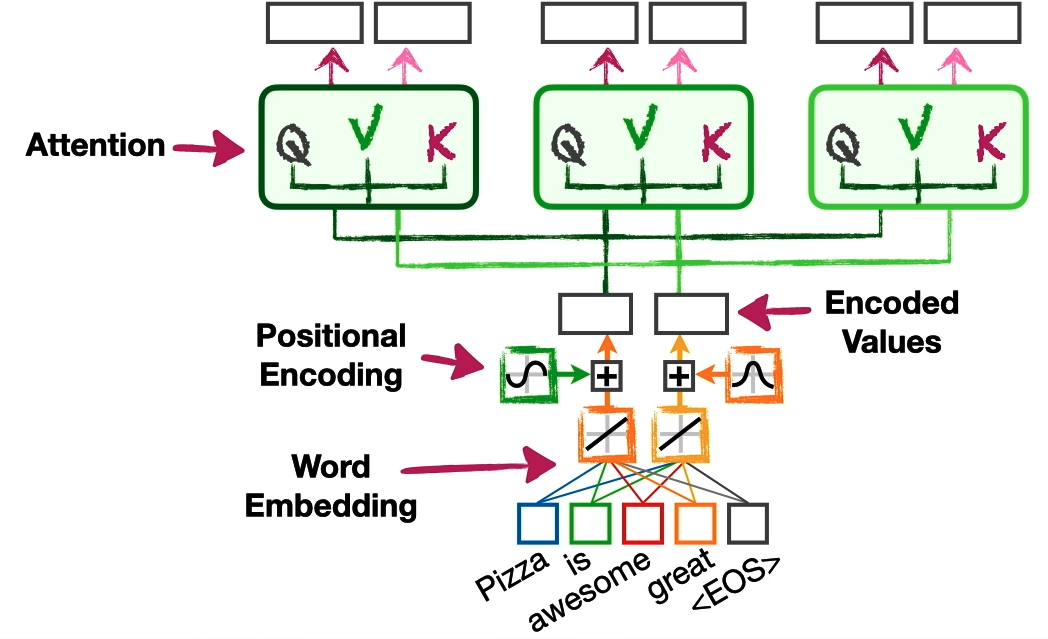

In [1]:
# Importing all necessary libraries
import torch
import torch.nn as nn

SEED = 42

In [2]:
# The Attention class to compute both Self-Attention and Masked Self-Attention Scores.
class Attention(nn.Module):
    def __init__(self, d_model, row_dim=0, col_dim=1):
        
        super().__init__()

        self.row_dim = row_dim
        self.col_dim = col_dim
        self.d_model = d_model

        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
    
    # Based on mask, its either self-attention or masked self-attention.
    def forward(self, q_encodings_matrix, k_encodings_matrix, v_encodings_matrix, mask=None):

        # Compute the query, key and values matrices using the corresponding encodings_matrix and their weights.
        q = self.W_q(q_encodings_matrix)
        k = self.W_k(k_encodings_matrix)
        v = self.W_v(v_encodings_matrix)

        similarity_scores = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))
        scaled_similarity_scores = similarity_scores / k.shape[-1] ** 0.5

        if mask is not None:
            scaled_similarity_scores = scaled_similarity_scores.masked_fill(mask=mask, value=-1e9)

        attention_probs = torch.softmax(scaled_similarity_scores, dim=self.col_dim)
        attention_scores = attention_probs @ v

        return attention_scores


In [3]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, row_dim=0, col_dim=1, num_heads=1):
        
        super().__init__()

        self.row_dim = row_dim
        self.col_dim = col_dim
        self.d_model = d_model

        self.heads = nn.ModuleList([Attention(d_model, row_dim, col_dim) for _ in range(num_heads)])


    def forward(self, q_encodings_matrix, k_encodings_matrix, v_encodings_matrix, mask=None):
        
        multi_headed_attention_scores = []
        for head in self.heads:
            curr_attention_head_scores = head(q_encodings_matrix, k_encodings_matrix, v_encodings_matrix, mask=None)
            multi_headed_attention_scores.append(curr_attention_head_scores)
        
        # Concatenate these individual attention scores.
        multi_headed_attention_scores = torch.cat(multi_headed_attention_scores, dim=self.col_dim)

        return multi_headed_attention_scores



### Defining the Input Encodings for the Self Attention, Masked Self Attention and Multi-Headed Self Attention Computations

In [4]:
q_encodings_matrix = torch.tensor([[1.16, 0.23],
                                 [0.57, 1.36],
                                 [4.41, -2.16]
                                 ])

k_encodings_matrix = torch.tensor([[1.16, 0.23],
                                 [0.57, 1.36],
                                 [4.41, -2.16]
                                 ])

v_encodings_matrix = torch.tensor([[1.16, 0.23],
                                 [0.57, 1.36],
                                 [4.41, -2.16]
                                 ])

In [17]:
# # set the seed before initializing the parent nn.Module class.
torch.manual_seed(SEED)

### Testing the Attention class - Self Attention

In [18]:
# Instantiating the Attention class to perform self-attention.
self_attention = Attention(d_model=2, row_dim=0, col_dim=1)

In [19]:
attention_scores = self_attention(q_encodings_matrix, k_encodings_matrix, v_encodings_matrix)

In [20]:
attention_scores

tensor([[1.0100, 1.0641],
        [0.2040, 0.7057],
        [3.4989, 2.2427]], grad_fn=<MmBackward0>)

### Testing the Attention class - Masked Self Attention

In [22]:
mask = torch.tril(torch.ones(q_encodings_matrix.shape[0], q_encodings_matrix.shape[0]))
mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [23]:
mask = mask == 0
mask

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [29]:
masked_attention_scores = self_attention(q_encodings_matrix, k_encodings_matrix, v_encodings_matrix, mask)

In [30]:
masked_attention_scores

tensor([[ 0.6038,  0.7434],
        [-0.0062,  0.6072],
        [ 3.4989,  2.2427]], grad_fn=<MmBackward0>)

### Testing Multi-Headed Self Attention

In [31]:
torch.manual_seed(42)

In [32]:
multi_headed_attention = MultiHeadedAttention(d_model=2, row_dim=0, col_dim=1, num_heads=2)

In [33]:
mha_scores = multi_headed_attention(q_encodings_matrix, k_encodings_matrix, v_encodings_matrix)

In [34]:
mha_scores

tensor([[ 1.0100,  1.0641, -0.7081, -0.8268],
        [ 0.2040,  0.7057, -0.7417, -0.9193],
        [ 3.4989,  2.2427, -0.7190, -0.8447]], grad_fn=<CatBackward0>)